<a href="https://colab.research.google.com/github/DanteReyesM/DataScienceEcosystem/blob/main/Getting_Started_with_Titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
pd.set_option('display.max_rows', None)
route = '/Titanic_train.csv'
df_train = pd.read_csv(route)
df_train.replace(' ',np.nan,inplace=True)
print(df_train.isna().sum()/len(df_train)*100)

PassengerId     0.000000
Survived        0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            19.865320
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.000000
Cabin          77.104377
Embarked        0.224467
dtype: float64


In [37]:
df_train['Cabin'].replace(np.nan,'Unknown',inplace=True)
df_train.dropna(subset=['Embarked'],inplace=True)
df_train.drop(columns=['PassengerId','Name','Ticket'],inplace=True)


/tmp/ipython-input-664418664.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_train['Cabin'].replace(np.nan,'Unknown',inplace=True)


In [42]:
print(df_train.isna().sum()/len(df_train)*100)

Survived     0.000000
Pclass       0.000000
Sex          0.000000
Age         19.910011
SibSp        0.000000
Parch        0.000000
Fare         0.000000
Cabin        0.000000
Embarked     0.000000
dtype: float64


In [46]:
X = df_train.drop('Survived', axis=1)
y = df_train['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
numerical_cols = X_train.select_dtypes(include=["int64", "float64"]).columns
categorical_cols = X_train.select_dtypes(include=["object"]).columns

In [47]:
from sklearn.impute import SimpleImputer
imputer_num = SimpleImputer(strategy='median')
X_train[numerical_cols] = imputer_num.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = imputer_num.transform(X_test[numerical_cols])

In [48]:
print(X_test.isna().sum()/len(df_train)*100)

Pclass      0.0
Sex         0.0
Age         0.0
SibSp       0.0
Parch       0.0
Fare        0.0
Cabin       0.0
Embarked    0.0
dtype: float64


In [52]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_train_encoded_raw = encoder.fit_transform(X_train[categorical_cols])
X_test_encoded_raw = encoder.transform(X_test[categorical_cols])

In [53]:
encoded_cols = encoder.get_feature_names_out(categorical_cols)

In [54]:
X_train_encoded = pd.DataFrame(X_train_encoded_raw, columns=encoded_cols, index=X_train.index)
X_test_encoded = pd.DataFrame(X_test_encoded_raw, columns=encoded_cols, index=X_test.index)

In [56]:
X_train_final = pd.concat([X_train[numerical_cols], X_train_encoded], axis=1)
X_test_final = pd.concat([X_test[numerical_cols], X_test_encoded], axis=1)

print(f"Dataset listo. Nuevas dimensiones: {X_train_final.shape}")

Dataset listo. Nuevas dimensiones: (711, 140)


In [61]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_final)
X_test_scaled = scaler.transform(X_test_final)
X_train_ready = pd.DataFrame(X_train_scaled, columns=X_train_final.columns, index=X_train_final.index)
X_test_ready = pd.DataFrame(X_test_scaled, columns=X_test_final.columns, index=X_test_final.index)

In [62]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score

In [66]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 1. Cambiamos el modelo a Clasificador
model_xgb = XGBClassifier(
    n_estimators=100, # Bajamos esto para empezar, 1000 suele ser demasiado sin early stopping
    learning_rate=0.1,
    max_depth=3,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

# 2. Entrenamos
model_xgb.fit(X_train_ready, y_train)

# 3. Predecimos clases (0 o 1), no valores continuos
y_pred = model_xgb.predict(X_test_ready)

# 4. Evaluamos con métricas de clasificación
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred))

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:200: UserWarning: [03:46:04] WARNING: /__w/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy: 0.8090

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.83      0.86      0.85       109
           1       0.77      0.72      0.75        69

    accuracy                           0.81       178
   macro avg       0.80      0.79      0.80       178
weighted avg       0.81      0.81      0.81       178



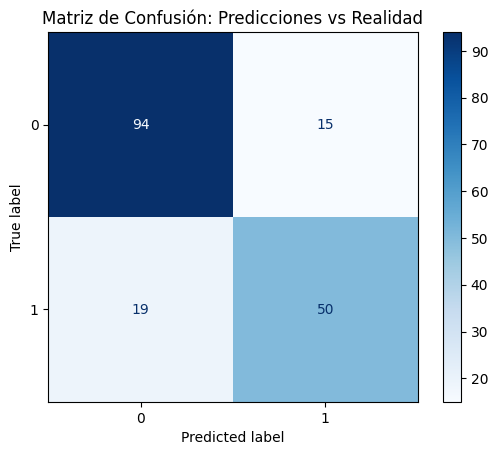

In [67]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title('Matriz de Confusión: Predicciones vs Realidad')
plt.show()

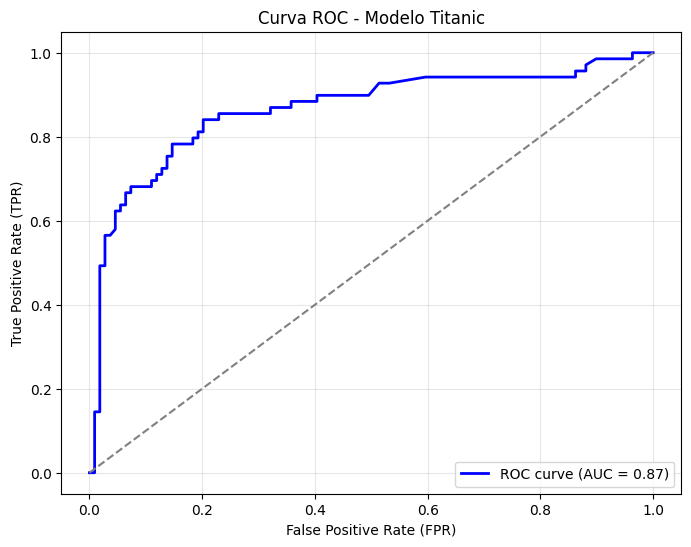

El AUC de tu modelo es: 0.8653


In [68]:
from sklearn.metrics import roc_curve, roc_auc_score

# 1. Obtenemos las probabilidades de la clase positiva (1)
y_probs = model_xgb.predict_proba(X_test_ready)[:, 1]

# 2. Calculamos los puntos de la curva y el AUC
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
auc_score = roc_auc_score(y_test, y_probs)

# 3. Graficamos
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--') # Línea de azar
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Curva ROC - Modelo Titanic')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

print(f"El AUC de tu modelo es: {auc_score:.4f}")

<Figure size 1000x800 with 0 Axes>

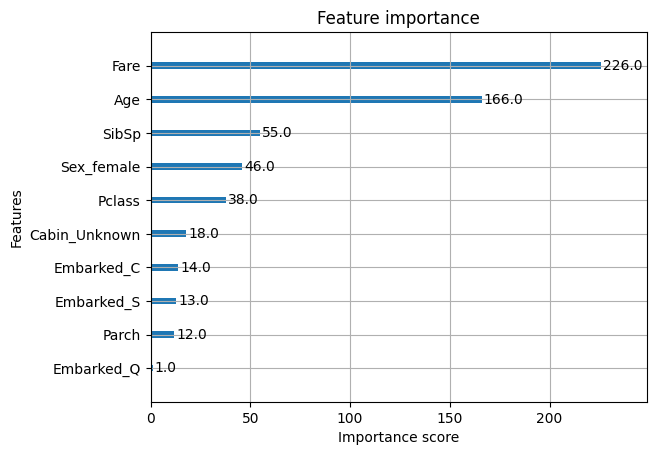

In [69]:
plt.figure(figsize=(10, 8))
xgb.plot_importance(model_xgb, max_num_features=15)
plt.show()

In [72]:
# 1. Ajuste necesario: Definir el imputador categórico que faltaba
# En tu entrenamiento usaste reemplazos manuales, pero para la función
# es más eficiente un imputer que use la misma lógica.
from sklearn.impute import SimpleImputer
cat_imputer = SimpleImputer(strategy='constant', fill_value='Unknown')

# Ajustamos el imputer con los datos de entrenamiento (antes de la función)
X_train[categorical_cols] = cat_imputer.fit_transform(X_train[categorical_cols])

# 2. Redefinición de la función (Específica para Titanic)
def procesar_test_titanic(file_path_test, numerical_cols, categorical_cols, imputer_num, cat_imputer, encoder, scaler):
    # Carga de datos
    df_test_raw = pd.read_csv(file_path_test)

    # Guardamos los IDs para el archivo final (En Titanic es PassengerId)
    passenger_ids = df_test_raw['PassengerId']

    # Limpieza inicial: Replicamos lo que hiciste en el entrenamiento
    df_test_raw['Cabin'].replace(np.nan, 'Unknown', inplace=True)
    df_test_raw.drop(columns=['PassengerId', 'Name', 'Ticket'], inplace=True, errors='ignore')

    # Imputación de nulos
    df_test_raw[numerical_cols] = imputer_num.transform(df_test_raw[numerical_cols])
    df_test_raw[categorical_cols] = cat_imputer.transform(df_test_raw[categorical_cols])

    # Encoding (Categorización)
    test_encoded_raw = encoder.transform(df_test_raw[categorical_cols])
    encoded_cols = encoder.get_feature_names_out(categorical_cols)
    df_test_encoded = pd.DataFrame(test_encoded_raw, columns=encoded_cols, index=df_test_raw.index)

    # Unión de tablas y Escalado
    df_test_combined = pd.concat([df_test_raw[numerical_cols], df_test_encoded], axis=1)
    test_scaled = scaler.transform(df_test_combined)

    # DataFrame final listo para el modelo
    X_test_ready_output = pd.DataFrame(test_scaled, columns=df_test_combined.columns, index=df_test_combined.index)

    return X_test_ready_output, passenger_ids

# 3. Ejecución del proceso
# Asegúrate de que esta ruta apunte a tu archivo titanic_test.csv
ruta_test_titanic = '/titanic_test.csv'

X_kaggle_ready, passenger_ids = procesar_test_titanic(
    ruta_test_titanic,
    numerical_cols,
    categorical_cols,
    imputer_num,    # El que definiste arriba para la mediana
    cat_imputer,    # El que definimos arriba para 'Unknown'
    encoder,
    scaler
)

# 4. Predicción y Creación del archivo CSV
y_final_pred = model_xgb.predict(X_kaggle_ready)

submission = pd.DataFrame({
    'PassengerId': passenger_ids,
    'Survived': y_final_pred
})

# Guardar el archivo final
submission.to_csv('submission_titanic.csv', index=False)

print(f"¡Análisis de causa raíz completado! Archivo generado con {submission.shape[0]} filas.")

¡Análisis de causa raíz completado! Archivo generado con 418 filas.


/tmp/ipython-input-2988620636.py:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_test_raw['Cabin'].replace(np.nan, 'Unknown', inplace=True)
